# Import packages

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, Dataset, DataLoader

import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import argparse
from argparse import Namespace

import os
import random
from tqdm import tqdm

# import tensorflow as tf
import tensorboard
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from resnet import resnet18, resnet34, resnet50
from datetime import datetime as dt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [24]:
device

device(type='cuda')

# Dataset

In [25]:
particle2idx = {
    '1fpv': 0,
    '1ss8': 1,
    '3j03': 2,
    '1ijg': 3,
    '3iyf': 4,
    '6ody': 5,
    '6sp2': 6,
    '6xs6': 7,
    '7dwz': 8,
    '7dx8': 9,
    '7dx9': 10
}

count2idx = {
    'single': 0,
    'double': 1,
    'triple': 2,
    'quadruple': 3
}

In [26]:
idx2particle = {
    0: '1fpv',
    2: '1ss8',
    2: '3j03',
    3: '1ijg',
    4: '3iyf',
    5: '6ody',
    6: '6sp2',
    7: '6xs6',
    8: '7dwz',
    9: '7dx8',
    10: '7dx9'
}

idx2count = {
    0: 'single',
    1: 'double',
    2: 'triple',
    3: 'quadruple'
}

In [27]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, particles, counts, transform=None, seed=1234):
        self.root_dir = root_dir
        self.transform = transform

        self.count_labels = []
        self.particle_labels = []
        self.data = []

        for particle in particles:
            for count in counts:
                if count == 'single':
                    n = 4
                else:
                    n = 1
                data_dir = f'{self.root_dir}/SPI_{particle}_{str(n)}k_{count}_thumbnail.h5'
#                 if not os.path.exists(data_dir):
#                     continue
                # Load images as h5 files
                f = h5py.File(data_dir, 'r')
                dset_name = list(f.keys())[0]
                data = f[dset_name]
                data = [Image.fromarray(data[i]) for i in range(LENGTH * n)]
                data = [self.transform(data[i]) for i in range(LENGTH * n)]
                count_label = [count2idx[count]] * (LENGTH * n)
                particle_label = [particle2idx[particle]] * (LENGTH * n)
                self.data.extend(data)
                self.count_labels.extend(count_label)
                self.particle_labels.extend(particle_label)
        
        # Shuffle the data
        random.seed(seed)
        perm = list(range(len(self.data)))
        random.shuffle(perm)
        self.data = [self.data[i] for i in perm]
        self.count_labels = [self.count_labels[i] for i in perm]
        self.particle_labels = [self.particle_labels[i] for i in perm]

    def __len__(self):
        '''Denotes the total number of samples'''
        return len(self.data)

    def __getitem__(self, index):
        '''Generates one sample of data'''
        X = self.data[index]
        count = self.count_labels[index]
        particle = self.particle_labels[index]
        return X, count, particle

# Dataloader

In [28]:
def get_dataloaders(args, train_val_particles, test_particles, test_diff_particle=False):
    transform = transforms.Compose([transforms.CenterCrop(128),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])
    data_len = args.num_particles * 7000
    
    if not test_diff_particle:
        assert train_val_particles == test_particles
        dataset = CustomDataset(root_dir=args.root_dir,
                                particles=train_val_particles,
                                counts=COUNTS,
                                transform=transform)
        print(len(dataset))
        train_idx = list(range(0, int(data_len * 0.7)))
        valid_idx = list(range(int(data_len * 0.7), int(data_len * 0.8)))
        test_idx = list(range(int(data_len * 0.8), data_len))
        train_dataset = Subset(dataset, train_idx) 
        valid_dataset = Subset(dataset, valid_idx)
        test_dataset = Subset(dataset, test_idx)
    else:
        # Create train/valid/test datasets
        train_val_dataset = CustomDataset(root_dir=args.root_dir, 
                                          particles=train_val_particles,
                                          counts=COUNTS,
                                          transform=transform)
        train_idx = list(range(0, 7000))
        valid_idx = list(range(7000, 8000))
        train_dataset = Subset(train_val_dataset, train_idx) 
        valid_dataset = Subset(train_val_dataset, valid_idx)
        test_dataset = CustomDataset(root_dir=args.root_dir, 
                                    particles=test_particles,
                                    counts=COUNTS,
                                    transform=transform)
        
        assert train_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert valid_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert test_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])

    # Create train/valid/test dataloaders
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    valid_dataloader = DataLoader(dataset=valid_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    test_dataloader = DataLoader(dataset=test_dataset, 
                                 batch_size=args.batch_size, 
                                 shuffle=args.shuffle, 
                                 num_workers=args.num_workers)
    return train_dataloader, valid_dataloader, test_dataloader

In [7]:
# transform = transforms.Compose([transforms.CenterCrop(128),
#                                 transforms.RandomVerticalFlip(p=0.5),
#                                 transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.ToTensor()])
# dataset = CustomDataset(root_dir=args.root_dir,
#                         particles=PARTICLES,
#                         counts=COUNTS,
#                         transform=transform)

In [8]:
# i = 0
# for idx, (X, count, particle) in enumerate(dataset):
#     if particle == 6:
#         i += 1
# #         print(particle)
# i

In [9]:
# train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(args, 
#                                                                       PARTICLES, 
#                                                                       PARTICLES, 
#                                                                       test_diff_particle=False)

In [10]:
# for i, (X, count, particle) in enumerate(train_dataloader):
#     i = 10
# #     print(X[i].shape)
#     img = X[i].numpy().squeeze(axis=0)
# #     print(img)
#     plt.imshow(img, vmin=0, vmax=20)
#     plt.show()
#     print(idx2count[int(count[i])])
#     print(idx2particle[int(particle[i])])
#     break

# Utils

In [ ]:
import random
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [11]:
def read_thumbnails(fname):
    f = h5py.File(fname, 'r')
    dset_name = list(f.keys())[0]
    print("Check the datasets keys: " + str(list(f.keys())))
    
    dset = f[dset_name]
    print("Check the shape of the dataset: " + str(dset.shape))
    
    print(len(dset))
    w=20
    h=20
    fig=plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = dset[5* i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0, vmax=10)
    plt.show()

In [12]:
root_dir = './data/thumbnail'

In [12]:
fout = h5py.File(f'{root_dir}/SPI_{particle}_4k_single_thumbnail.h5','w')
ds = fout.create_dataset('photons', (4000, 128, 130), dtype='float32')
for i in range(4000):
    ds[i,:,:] = dataset[i]
fout.close()

Check the datasets keys: ['photons']
Check the shape of the dataset: (1000, 128, 130)
1000


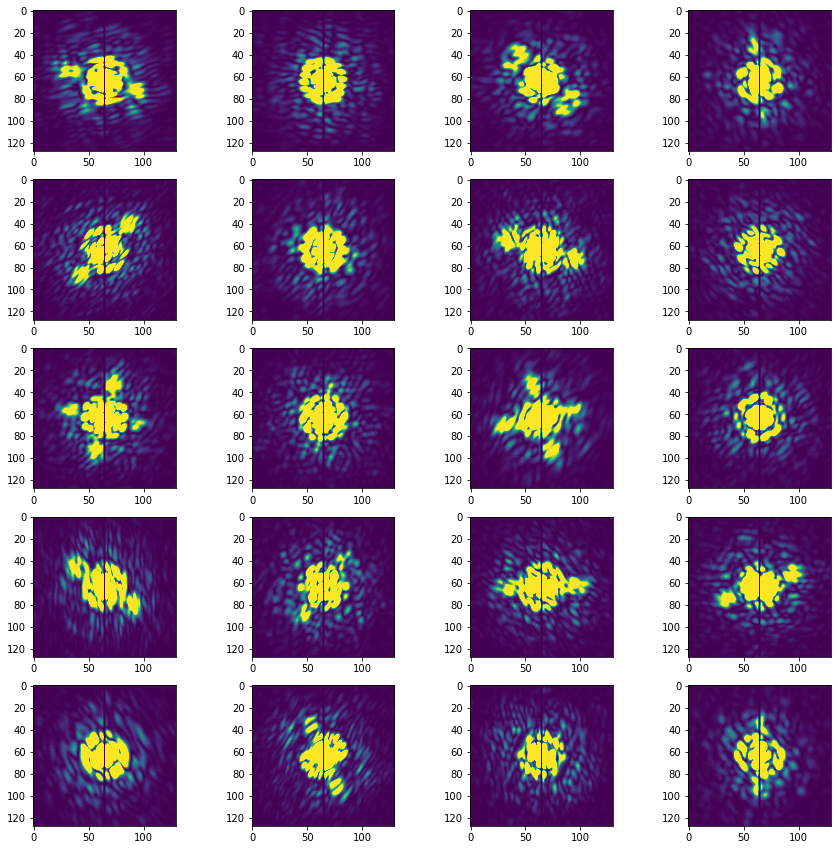

In [30]:
particle = '1ss8'
root_dir = './data/thumbnail'
image_dir = f'{root_dir}/SPI_{particle}_1k_quadruple_thumbnail.h5'
# image_dir = f'{root_dir}/SPI_{particle}_4k_single_thumbnail.h5'

read_thumbnails(image_dir)

# Models

## Multi-output CNN

In [34]:
# class MultiOutputCNN(nn.Module):
#     def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
#         super(MultiOutputCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
#         self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
#         self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
#         self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
#         self.conv5 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 2, 2) # (128, 4, 4)
#         self.dropout1 = nn.Dropout(0.25)
#         self.dropout2 = nn.Dropout(0.5)
#         self.fc1 = nn.Linear(2048, 128)
#         self.fc2 = nn.Linear(2048, num_counts)
#         self.fc3 = nn.Linear(2048, num_particles)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(x)
#         x = self.conv4(x)
#         x = F.relu(x)
#         x = self.conv5(x)
#         x = F.relu(x)
#         # x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)

#         y1 = self.fc2(x)
#         y1 = F.log_softmax(y1, dim=1)
#         y2 = self.fc3(x)
#         y2 = F.log_softmax(y2, dim=1)
#         return y1, y2

### Multi-output CNN (Branched 2)

In [11]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
        
        #Brached
        self.conv3_b1 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4_b1 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5_b1 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 2, 2) # (128, 4, 4)
        self.dropout1_b1 = nn.Dropout(0.25)
        self.dropout2_b1 = nn.Dropout(0.5)
        self.fc1_b1 = nn.Linear(2048, num_counts)
#         self.fc2_b1 = nn.Linear(512, 256)
#         self.fc3_b1 = nn.Linear(256, 128)
#         self.fc4_b1 = nn.Linear(128, num_counts)
        
        self.conv3_b2 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4_b2 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5_b2 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 2, 2) # (128, 4, 4)
        self.dropout1_b2 = nn.Dropout(0.25)
        self.dropout2_b2 = nn.Dropout(0.5)
        self.fc1_b2 = nn.Linear(2048, num_particles)
#         self.fc2_b2 = nn.Linear(512, 256)
#         self.fc3_b2 = nn.Linear(256, 128)
#         self.fc4_b2 = nn.Linear(128, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        #Brached
        y1 = self.conv3_b1(x)
        y1 = F.relu(y1)
        y1 = self.conv4_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv5_b1(y1)
        y1 = F.relu(y1)
        y1 = self.dropout1_b1(y1)
        y1 = torch.flatten(y1, 1)
        y1 = self.fc1_b1(y1)
#         y1 = F.relu(y1)
#         y1 = self.dropout2_b1(y1)
#         y1 = self.fc2_b1(y1)
#         y1 = self.fc3_b1(y1)
#         y1 = self.fc4_b1(y1)
        y1 = F.log_softmax(y1, dim=1)

        y2 = self.conv3_b2(x)
        y2 = F.relu(y2)
        y2 = self.conv4_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv5_b2(y2)
        y2 = F.relu(y2)
        y2 = self.dropout1_b2(y2)
        y2 = torch.flatten(y2, 1)
        y2 = self.fc1_b2(y2)
#         y2 = F.relu(y2)
#         y2 = self.dropout2_b2(y2)
#         y2 = self.fc2_b2(y2)
#         y2 = self.fc3_b2(y2)
#         y2 = self.fc4_b2(y2)
        y2 = F.log_softmax(y2, dim=1)

        return y1, y2

In [14]:
# model = MultiOutputCNN()

In [15]:
# model = model.to(device)

In [16]:
# summary(model, input_size=(1, 128, 128))

## Multi-output ResNet18

In [29]:
class MyModel(nn.Module):
    def __init__(self, num_counts, num_particles):
        super(MyModel, self).__init__()
        self.model_resnet = models.resnet18(pretrained=False)
        self.model_resnet.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=True)
        
        self.model_resnet.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
        
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_counts)
        self.fc2 = nn.Linear(num_ftrs, num_particles)
    def forward(self, x):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        y1 = F.log_softmax(out1, dim=1)
        out2 = self.fc2(x)
        y2 = F.log_softmax(out2, dim=1)
        return y1, y2

In [30]:
num_counts = 4
num_particles = 11

model = (MyModel(num_counts, num_particles))
model

MyModel(
  (model_resnet): ResNet(
    (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

# Evalutate

In [31]:
def evaluate(model, loss_fn, dataloader):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
    """
    model.eval()

    accuracies = []
    loss = 0.0
    all_preds = []
    all_labels = []
    preds1 = []
    preds2 = []
    all_count_labels = []
    all_particle_labels = []
    for i, (inputs, count_labels, particle_labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        if not args.multi_output:
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, count_labels.squeeze(0).to(device))
            loss += batch_loss
            preds = torch.argmax(outputs, dim=-1)
            all_preds.append(preds)
            all_labels.append(count_labels)
            loss = loss / len(dataloader)
        else:
            y1, y2 = model(inputs)
            loss1 = loss_fn(y1, count_labels.squeeze(0).to(device)).detach().item()
            loss2 = loss_fn(y2, particle_labels.squeeze(0).to(device)).detach().item()
            batch_loss = loss1 + loss2
            loss += batch_loss
            y1 = torch.argmax(y1, dim=-1).to('cpu').numpy().tolist()
            y2 = torch.argmax(y2, dim=-1).to('cpu').numpy().tolist()
            
            preds1.extend(y1)
            preds2.extend(y2)
            all_count_labels.extend(count_labels.to('cpu').numpy().tolist())
            all_particle_labels.extend(particle_labels.to('cpu').numpy().tolist())
    
    torch.cuda.empty_cache()
    
    # Total accuracy
    correct_pred = [1 if (preds1[i] == all_count_labels[i] and preds2[i] == all_particle_labels[i]) else 0 for i in range(len(preds1))]
    accuracy = sum(correct_pred) / len(preds1) * 100
    
    # Count accuracy
    correct_pred_count = [1 if (preds1[i] == all_count_labels[i]) else 0 for i in range(len(preds1))]
    count_accuracy = sum(correct_pred_count) / len(preds1) * 100
    
    # Particle accuracy
    correct_pred_particle = [1 if (preds2[i] == all_particle_labels[i]) else 0 for i in range(len(preds2))]
    particle_accuracy = sum(correct_pred_particle) / len(preds1) * 100
    
    loss = loss / len(dataloader)

    return accuracy, count_accuracy, particle_accuracy, loss

In [32]:
"""
Define evaluation metric

We will use accuracy as an evaluation metric
"""

def calculate_accuracy(loader):
    total = 0
    correct = 0
  
    all_images = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.squeeze().to(device)).sum().item()
            
            all_images.append(images)
            all_preds.append(predicted.cpu().data.numpy())
            all_labels.append(labels)

    return 100 * correct / total, all_images, all_preds, all_labels

# Train

In [33]:
def train(args, model, optimizer, loss_fn):
    """""
    Train the network on the training data
    """
    # writer = SummaryWriter(args.logdir)

    EPOCH = args.epoches

    train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(args, 
                                                                          PARTICLES, 
                                                                          PARTICLES,
                                                                          test_diff_particle=False)
    step = 0

    train_loss_values = []
    train_accuracies = {
        'Total': [],
        'Count': [],
        'Particle': []
    }
    valid_loss_values = []
    valid_accuracies = {
        'Total': [],
        'Count': [],
        'Particle': []
    }
    for epoch in range(EPOCH):
        epoch_train_loss = 0.0
        with tqdm(total=len(train_dataloader)) as t: 
            for i, (inputs, count_labels, particle_labels) in enumerate(train_dataloader):
                step += 1
                model.train()

                inputs = inputs.to(device)
                
                if not args.multi_output:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, count_labels.squeeze(0).to(device))
                else:
                    y1, y2 = model(inputs)
                    loss1 = loss_fn(y1, count_labels.squeeze(0).to(device))
                    loss2 = loss_fn(y2, particle_labels.squeeze(0).to(device))
                    loss = loss1 + loss2
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                cost = loss.item()
                
                epoch_train_loss = cost
                
                t.set_postfix(train_loss='{:05.3f}'.format(cost))
                t.update()
                
                # torch.cuda.empty_cache()
        
        if epoch % args.evaluate_every == 0:
            valid_accuracy, valid_count_accuracy, valid_particle_accuracy, valid_loss = evaluate(model, criterion, valid_dataloader)
            valid_accuracies['Total'].append(valid_accuracy)
            valid_accuracies['Count'].append(valid_count_accuracy)
            valid_accuracies['Particle'].append(valid_particle_accuracy)
            valid_loss_values.append(valid_loss)
            
            train_accuracy, train_count_accuracy, train_particle_accuracy, train_loss = evaluate(model, criterion, train_dataloader)
            train_accuracies['Total'].append(train_accuracy)
            train_accuracies['Count'].append(train_count_accuracy)
            train_accuracies['Particle'].append(train_particle_accuracy)
            train_loss_values.append(train_loss)
            
#             epoch_valid_loss = valid_loss
#             writer.add_scalar("valid/loss", loss, step)
#             writer.add_scalar("valid/accuracy", accuracy, step)
#             writer.add_scalar("train/loss", cost, step)
            print(f'Step {step}: train loss={train_loss}, \n train accuracy={train_accuracy}, \n train count accuracy={train_count_accuracy}, \n train particle accuracy={train_particle_accuracy}')

    torch.save(model.state_dict(), args.ckpt_path)
    
    plot_loss(args, train_loss_values, 'train')
    plot_accuracies(args, train_accuracies, 'train')
    plot_loss(args, valid_loss_values, 'validation')
    plot_accuracies(args, valid_accuracies, 'validation')
#     """
#     Plot the epoch loss
#     """
#     plt.figure(figsize=(7,5))
#     # plt.title("Training and Validation Loss")
#     plt.title("Training Loss")
#     # plt.plot(valid_loss_values,label="val", color='r')
#     plt.plot(train_loss_values,label="train", color='b')
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.savefig(f'{args.logdir}/{args.model}_train_loss_{dt.now()}.png')
#     plt.show()

    """
    Report results on the train and test data (using the evaluation metric)
    """
    test_accuracy, test_count_accuracy, test_particle_accuracy, _ = evaluate(model, criterion, test_dataloader)
    print('Test accuracy: %f' % test_accuracy)
    print('Test count accuracy: %f' % test_count_accuracy)
    print('Test particle accuracy: %f' % test_particle_accuracy)

    # return images, preds, labels

In [34]:
def plot_accuracies(args, accuracies, split):
    plt.figure(figsize=(7,5))
    # plt.title("Training and Validation Loss")
    plt.title("Total, count, and particle accuracies")
    plt.plot(accuracies['Total'], label="Total", color='r')
    plt.plot(accuracies['Count'], label="Count", color='g')
    plt.plot(accuracies['Particle'], label="Particle", color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'{args.logdir}/{args.model}_{split}_accuracies_{dt.now()}.png')
    plt.show()

In [35]:
def plot_loss(args, loss_values, split):
    plt.figure(figsize=(7,5))
    # plt.title("Training and Validation Loss")
    plt.title(f"{split} Loss")
    # plt.plot(valid_loss_values,label="val", color='r')
    plt.plot(loss_values,label="train", color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'{args.logdir}/{args.model}_{split}_loss_{dt.now()}.png')
    plt.show()

# Run the pipeline

In [36]:
def load_model(args):
#     if args.model == 'mlp':
#         input_dim = 128 * 128
#         output_dim = 3
#         model = MLP(INPUT_DIM, OUTPUT_DIM).to(device)
#     elif args.model == 'cnn':
#         num_classes = 4
#         hidden_dim = 8
#         model = CNN(num_classes, hidden_dim).to(device)
    if args.model == 'multi_output_cnn':
        num_particles = args.num_particles
        num_counts = args.num_counts
        hidden_dim = 8
        model = MultiOutputCNN(num_particles=num_particles, num_counts=num_counts, hidden_dim=hidden_dim).to(device)
    elif args.model == 'multi_output_resnet18':
        num_particles = args.num_particles
        num_counts = args.num_counts
        model = MyModel(num_counts, num_particles).to(device)
#         model = resnet18().to(device)
#     elif args.model == 'multi_output_resnet34':
#         model = resnet34().to(device)
#     elif args.model == 'multi_output_resnet50':
#         model = resnet50().to(device)
#     elif args.model == 'vgg11':
#         vgg11 = models.vgg11(pretrained=False)
#         vgg11.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         model = vgg11.to(device)
#     elif args.model == 'resnet18':
#         resnet18 = models.resnet18(pretrained=False)
#         resnet18.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
#         model = resnet18.to(device)
#     elif args.model == 'alexnet':
#         alexnet = models.alexnet(pretrained=False)
#         alexnet.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         model = alexnet.to(device)
    return model

In [37]:
PARTICLES = ['1fpv', '1ss8', '3j03', '1ijg', '3iyf', '6ody', '6sp2', '6xs6', '7dwz', '7dx8', '7dx9']
COUNTS = ['single', 'double', 'triple', 'quadruple']
LENGTH = 1000

In [41]:
args = {
    # multi_output_cnn || multi_output_resnet18 || multi_output_resnet34 || multi_output_resnet50
    'model': 'multi_output_resnet18',
    'root_dir': './data/thumbnail',
    'epoches': 20,
    'batch_size': 128,
    'shuffle': False,
    'num_workers': 1,
    'num_particles': 11,
    'num_counts': 4,
    'length': 1000,
    'evaluate_every': 1,
    'logdir': './logs',
    'multi_output': True
}
args = Namespace(**args)
args.ckpt_path = f'{args.logdir}/{args.model}_checkpoint.pth'

In [42]:
"""
Define loss function and optimizer

We will use the cross entropy loss and Adam optimizer
"""

# Create model
model = load_model(args)

# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

In [43]:
model

MyModel(
  (model_resnet): ResNet(
    (conv1): Conv1d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
train(args, model, optimizer, criterion)

  0%|          | 0/422 [00:00<?, ?it/s]

77000


  0%|          | 0/422 [00:00<?, ?it/s]

Step 422: train loss=15.849858967613836, 
 train accuracy=10.319109461966605, 
 train count accuracy=47.46382189239332, 
 train particle accuracy=24.302411873840445


  0%|          | 0/422 [00:00<?, ?it/s]

Step 844: train loss=4.719278462972686, 
 train accuracy=28.12059369202226, 
 train count accuracy=63.549165120593685, 
 train particle accuracy=55.31539888682746


 38%|███▊      | 161/422 [01:03<01:41,  2.56it/s, train_loss=0.391]

# Error analysis

In [17]:
import tensorboard
import tensorflow as tf
%load_ext tensorboard

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
tensorboard.__version__

'2.4.1'

In [ ]:
%cd /content/drive/Shareddrives/CS230/
%ls

/content/drive/Shareddrives/CS230
 checkpoints/
'experiment record'/
 logs/
 notebooks/
 resnet18_checkpoint.pth
 resnet_checkpoint
"Shawn's workspace"/
 Simulated/
'X-ray crystallography particle images classification.gslides'


In [ ]:
%tensorboard --logdir_spec 1:./logs --bind_all

In [ ]:
! tensorboard --logdir=d:/data --host 0.0.0.0

2021-05-15 23:38:42.904753: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
TensorBoard 2.4.1 at http://0.0.0.0:6006/ (Press CTRL+C to quit)


In [ ]:
##### VIEW PREDICTIONS #####
import matplotlib.pyplot as plt
import numpy as np


def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

images, labels, preds = unison_shuffled_copies(images, labels, preds)

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
flatted_axs = [item for one_ax in axs for item in one_ax]
for ax, img, label, pred in zip(flatted_axs, images[:25], labels[:25], preds[:25]):
    ax.imshow(np.reshape(img, (128, 128)))
    ax.set_title('l:{},p:{}'.format(label, pred))
    ax.axis('off')
plt.show()  